In [2]:
import torch
import pypose as pp
import numpy as np
import pandas as pd

from scipy.spatial.transform import Rotation as R

from utile import read_files, plot_traj

import os
from tqdm import tqdm
import random
random.seed(0)

import matplotlib.pyplot as plt

/home/pierre/anaconda3/envs/pypose/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "./data/csv/sub/run10.csv"
df = pd.read_csv(path)

In [4]:
pos = df.loc[:, ['x', 'y', 'z']].to_numpy()
euler = df.loc[:, ['roll', 'pitch', 'yaw']].to_numpy()
quat = df.loc[:, ['qx', 'qy', 'qz', 'qw']].to_numpy()
rot_vec = df.loc[:, ['rv0', 'rv1', 'rv2']].to_numpy()
rot_mat = df.loc[:, ['r00', 'r01', 'r02',
                     'r10', 'r11', 'r12',
                     'r20', 'r21', 'r22']].to_numpy().reshape((-1, 3, 3))
I_vel = df.loc[:, ['Iu', 'Iv', 'Iw', 'Ip', 'Iq', 'Ir']].to_numpy()
B_vel = df.loc[:, ['Bu', 'Bv', 'Bw', 'Bp', 'Bq', 'Br']].to_numpy()

gt_traj = np.concatenate([pos, euler], axis=-1)

In [5]:
def to_euler(x):
    pose = x.data.numpy()
    p = pose[0:3]
    q = pose[3:]
    r = R.from_quat(q)
    e = r.as_euler('xyz')
    return np.concatenate([p, e])

## Init SE3 group member from first state

In [6]:
dt = 0.1
x_init = pp.SE3(np.concatenate([pos[0], quat[0]]))

## Left $\oplus$

In [7]:
x = x_init
left_traj = np.zeros(shape=(gt_traj.shape[0], 6))
left_traj[0] = to_euler(x)

for i, v in enumerate(I_vel[:-1]):
    x_next = pp.se3(v*dt).Exp() * x
    left_traj[i+1] = to_euler(x_next)
    x = x_next

## Right $\oplus$

In [8]:
x = x_init
right_traj = np.zeros(shape=(gt_traj.shape[0], 6))
right_traj[0] = to_euler(x)

for i, v in enumerate(B_vel[:-1]):
    x_next = x * pp.se3(v*dt).Exp()
    right_traj[i+1] = to_euler(x_next)
    x = x_next

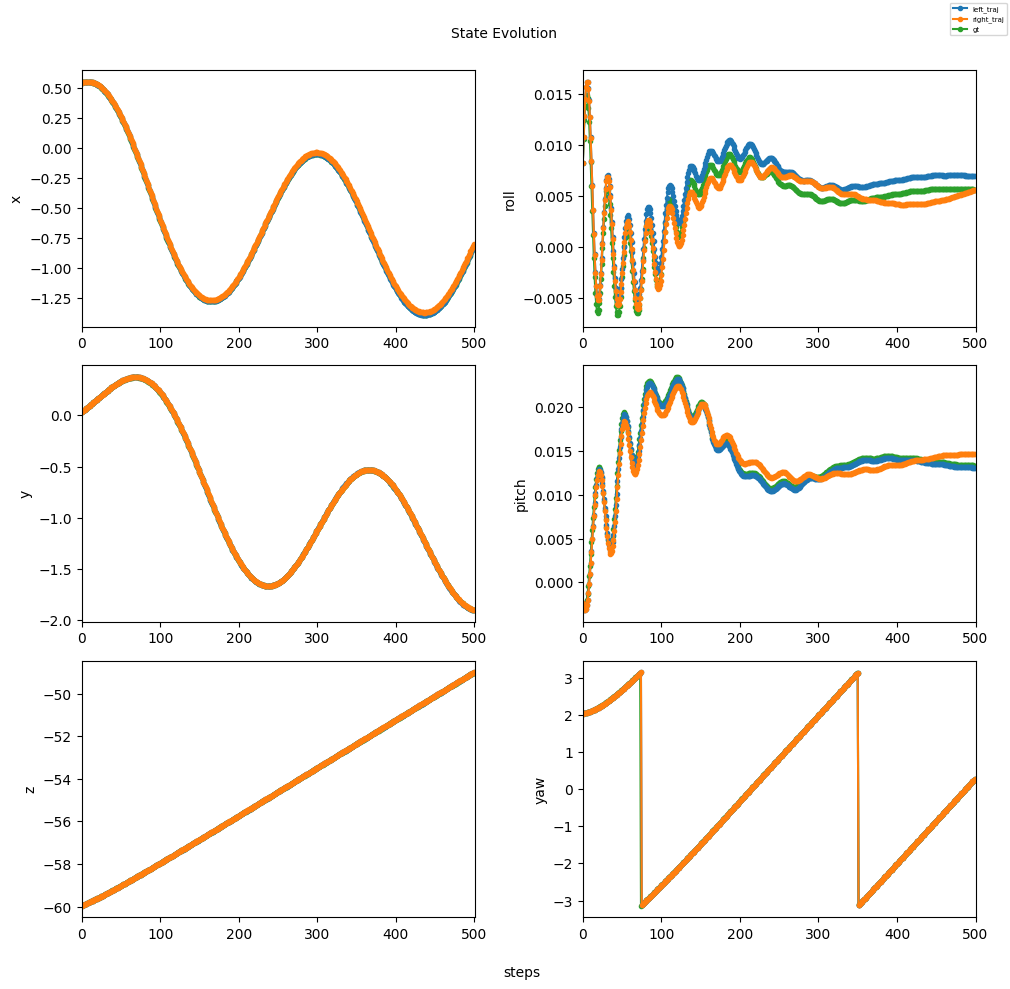

In [9]:
e_cols = {'x': 0, 'y': 1, 'z': 2, 'roll': 3, 'pitch': 4, 'yaw': 5}
plot_traj({"left_traj": left_traj, "right_traj": right_traj, "gt": gt_traj}, e_cols, 500, True, save=True);

In [10]:
# DATASET FOR 3D DATA
class DatasetList3D(torch.utils.data.Dataset):
    def __init__(self, data_list, steps=1, frame="Body"):
        super(DatasetList3D, self).__init__()
        self.data_list = data_list
        self.s = steps
        self.pos = ['x', 'y', "z"]
        self.rot = ['r00', 'r01', 'r02',
                    'r10', 'r11', 'r12',
                    'r20', 'r21', 'r22']
        self.lin_vel = ['Bu', 'Bv', 'Bw']
        self.ang_vel = ['Bp', 'Bq', 'Br']
        self.x_labels = self.pos + self.rot + self.lin_vel + self.ang_vel
        if frame == "Body":
            prefix = "B"
        elif frame == "Inertial":
            prefix = "I"
        self.y_labels = [f'{prefix}du', f'{prefix}dv', f'{prefix}dw', f'{prefix}dp', f'{prefix}dq', f'{prefix}dr']
        self.u_labels = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']

        self.samples = [traj.shape[0] - self.s for traj in data_list]
        self.len = sum(self.samples)
        self.bins = self.create_bins()

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # get the trajectory index of the current query
        i = (np.digitize([idx], self.bins)-1)[0]
        traj = self.data_list[i]
        j = idx - self.bins[i]
        sub_frame = traj.iloc[j:j+self.s+1]
        x = sub_frame[self.x_labels].to_numpy()
        x = x[:1]

        u = sub_frame[self.u_labels].to_numpy()
        u = u[:self.s]

        y = sub_frame[self.y_labels].to_numpy()
        y = y[1:self.s+1]
        return x, u, y

    @property
    def nb_trajs(self):
        return len(self.data_list)
    
    def get_traj(self, idx):
        if idx >= self.nb_trajs:
            raise IndexError
        return self.data_list[idx][self.x_labels].to_numpy()
    
    def create_bins(self):
        bins = [0]
        cummul = 0
        for s in self.samples:
            cummul += s
            bins.append(cummul)
        return bins

    def get_trajs(self):
        traj_list = []
        dv_traj_list = []
        action_seq_list = []
        for data in self.data_list:
            traj = data[self.x_labels].to_numpy()
            traj_list.append(traj)

            dv_traj = data[self.y_labels].to_numpy()
            dv_traj_list.append(dv_traj)

            action_seq = data[self.u_labels].to_numpy()
            action_seq_list.append(action_seq)
        return traj_list, dv_traj_list, action_seq_list


In [11]:
data_dir = "./data/csv/sub/"
dir_name = os.path.basename(data_dir)
files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
random.shuffle(files)

# split train and val in 70-30 ration
train_size = int(0.7*len(files))

train_files = files[:train_size]
val_files = files[train_size:]

print("Data size:  ", len(files))
print("Train size: ", len(train_files))
print("Val size:   ", len(val_files))

dfs_train = read_files(data_dir, train_files, "train")
dfs_val = read_files(data_dir, val_files, "val")

Data size:   50
Train size:  35
Val size:    15


Dir val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 131.90it/s]


In [12]:
dataset_train = DatasetList3D(dfs_train, steps=10)
dataset_val = DatasetList3D(dfs_val, steps=10)

(x, u, y) = dataset_train[0]
print("x: ", x.shape)
print("u: ", u.shape)
print("y: ", y.shape)

x:  (1, 18)
u:  (10, 6)
y:  (10, 6)


(10, 65)
x:  (1, 18)
u:  (10, 6)
y:  (9, 6)
(10, 65)
x:  (1, 18)
u:  (10, 6)
y:  (9, 6)
(10, 65)
x:  (1, 18)
u:  (10, 6)
y:  (9, 6)


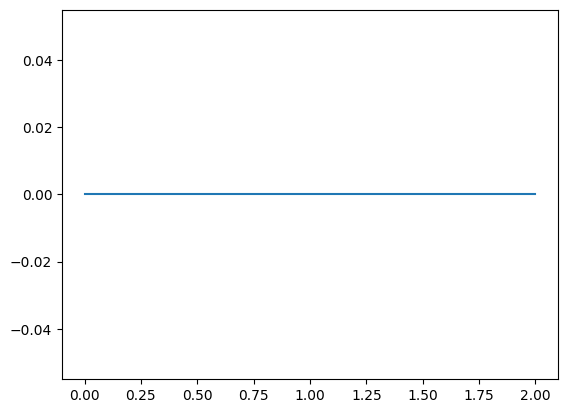

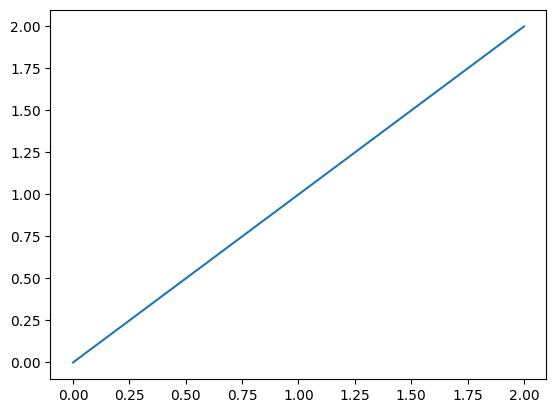

In [13]:
foo = []
bar = []
steps = 10
for idx in range(3):
    i = (np.digitize([idx], dataset_train.bins)-1)[0]
    traj = dataset_train.data_list[i]
    j = idx - dataset_train.bins[i]
    foo.append(i)
    bar.append(j)
    sub_frame = traj.iloc[j:j+steps]
    x = sub_frame[dataset_train.x_labels].to_numpy()
    x = x[:1]
    
    u = sub_frame[dataset_train.u_labels].to_numpy()
    u = u[:steps]

    y = sub_frame[dataset_train.y_labels].to_numpy()
    y = y[1:steps]

    print(sub_frame.shape)
    print("x: ", x.shape)
    print("u: ", u.shape)
    print("y: ", y.shape)


plt.figure()
plt.plot(np.array(foo))
plt.figure()
plt.plot(np.array(bar))


In [14]:
k = 2
tau = 1
in_size = 21
hid_size = 1
num_layers = 5

rnn = torch.nn.RNN(
    input_size=in_size,
    hidden_size=hid_size,
    num_layers=num_layers,
    bias=False,
    batch_first=True,
    nonlinearity="relu")

dummy = torch.rand(size=(k, tau, in_size))
h0 = torch.zeros(size=(num_layers, k, hid_size))

print("Input:", dummy)
print(dummy.shape)

print("h0:", h0)
print(h0.shape)

out, h = rnn(dummy, h0)

print("Out:", out)
print(out.shape)

print("h:", h)
print(h.shape)


Input: tensor([[[0.5271, 0.5529, 0.9053, 0.3057, 0.3517, 0.8042, 0.1664, 0.4853,
          0.7551, 0.8930, 0.6289, 0.2111, 0.0731, 0.6499, 0.7042, 0.6509,
          0.8491, 0.9642, 0.9279, 0.2412, 0.3801]],

        [[0.9267, 0.2300, 0.7122, 0.0910, 0.5366, 0.3338, 0.2909, 0.2271,
          0.0073, 0.9158, 0.0451, 0.5817, 0.6868, 0.0633, 0.6034, 0.3553,
          0.6744, 0.5525, 0.0562, 0.8287, 0.2023]]])
torch.Size([2, 1, 21])
h0: tensor([[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]]])
torch.Size([5, 2, 1])
Out: tensor([[[0.]],

        [[0.]]], grad_fn=<TransposeBackward1>)
torch.Size([2, 1, 1])
h: tensor([[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]]], grad_fn=<StackBackward0>)
torch.Size([5, 2, 1])


In [15]:
from RNN_AUV3D import AUVRNNDeltaV

In [16]:
dv_pred = AUVRNNDeltaV()

In [17]:
dv_pred.rnn(dummy)

(tensor([[[-0.0554]],
 
         [[ 0.1270]]], grad_fn=<TransposeBackward1>),
 tensor([[[ 0.3154],
          [-0.8553]],
 
         [[ 0.2720],
          [-0.6391]],
 
         [[-0.0874],
          [ 0.2030]],
 
         [[-0.0817],
          [ 0.1879]],
 
         [[-0.0554],
          [ 0.1270]]], grad_fn=<StackBackward0>))

In [26]:
print(out)

dv_pred.fc(out)

tensor([[[0.]],

        [[0.]]], grad_fn=<TransposeBackward1>)


RuntimeError: running_mean should contain 1 elements not 32

In [27]:
%matplotlib inline

# PyPose Loss Function on SE(3)

Given two SE(3) elements X1, X2

Compute the displacement between the two Poses. 

$d = X1 \circ X2^{-1}$

We then get the $\mathfrak{se(3)}$ representation.

$[u, \omega] = Log(d)$

This vector should be 0 for the same SE(3) elements.

The Loss is the sum of the vector.

In [28]:
p1 = np.array([0., 0., 0., 1., 0., 0., 1e-10])
p2 = np.array([0., 0., 0., 0., 0., 0., 1.])
 
X1 = pp.SE3(p1)
X2 = pp.SE3(p2)

In [29]:
d = (X1 * X2.Inv())

In [30]:
print(d)
print(d.Log().sum())

SE3Type LieTensor:
LieTensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
           0.0000e+00, 1.0000e-10])
tensor(3.1416)


In [31]:
def loss(X1, X2):
    d = (X1 * X2.Inv()).Log()
    left = d[:, None]
    right = d[..., None]
    return torch.matmul(left, right)[:, 0, 0]

# Angle Loss
Vary x & y of the angle-axis representation between [$-\pi, \pi$] and plot it

In [32]:
samples = 400

x = np.linspace(-np.pi, np.pi, samples)
y = np.linspace(-np.pi, np.pi, samples)

X, Y = np.meshgrid(x, y)

print(X.shape)
print(Y.shape)

X_lin, Y_lin = X.reshape((-1)), Y.reshape((-1))

length = X_lin.shape[0]

(400, 400)
(400, 400)


In [33]:
omega = np.zeros(shape=(length, 3))
omega[:, 0] = X_lin
omega[:, 1] = Y_lin

position = np.zeros(shape=(length, 3))
pose = np.concatenate([position, omega], axis=-1)
Pose = pp.se3(pose).Exp()

In [34]:
# Initalize GT

gt = np.zeros(shape=(length, 6))
gt_X = pp.se3(gt).Exp()

In [35]:
l = loss(gt_X, Pose).numpy()
l = l.reshape((samples, samples))
print(l.shape)

(400, 400)


/home/pierre/anaconda3/envs/pypose/lib/python3.9/site-packages/pypose/lietensor/lietensor.py:919: UserWarning: Tensor Shape Invalid by calling <slot wrapper '__getitem__' of 'torch._C._TensorBase' objects>, go to https://pypose.org/docs/main/generated/pypose.LieTensor
  warnings.warn('Tensor Shape Invalid by calling {}, ' \


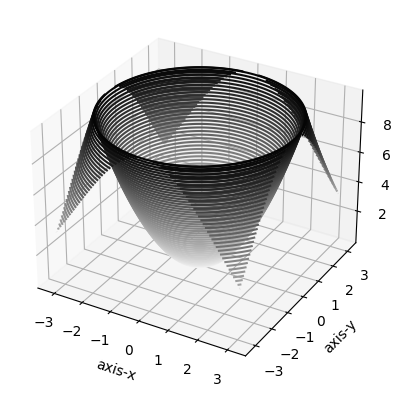

In [36]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, l, 50, cmap='binary')
ax.set_xlabel('axis-x')
ax.set_ylabel('axis-y')
ax.set_zlabel('loss');

# Position Loss
Vary x, y from $[-10, 10]$m and plot it

In [37]:
samples = 400
dist = 10

x = np.linspace(-dist, dist, samples)
y = np.linspace(-dist, dist, samples)

X, Y = np.meshgrid(x, y)

print(X.shape)
print(Y.shape)

X_lin, Y_lin = X.reshape((-1)), Y.reshape((-1))

length = X_lin.shape[0]

(400, 400)
(400, 400)


In [38]:
omega = np.zeros(shape=(length, 3))

position = np.zeros(shape=(length, 3))
position[:, 0] = X_lin
position[:, 1] = Y_lin

pose = np.concatenate([position, omega], axis=-1)
Pose = pp.se3(pose).Exp()

In [39]:
# Initalize GT
gt = np.zeros(shape=(length, 6))
gt_X = pp.se3(gt).Exp()

In [40]:
l = loss(gt_X, Pose).numpy()
l = l.reshape((samples, samples))
print(l.shape)

(400, 400)


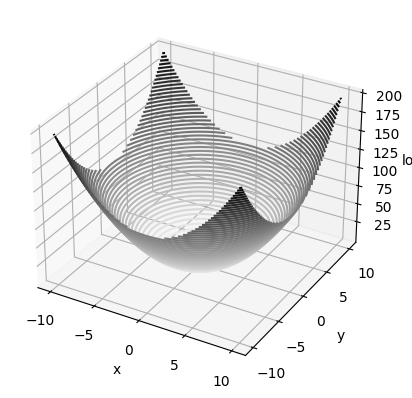

In [41]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, l, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('loss');

# Position Loss
Vary x from $[-10, 10]$m and axis-x from $[-\pi, \pi]$ plot it

In [42]:
samples = 400
dist = 10

x = np.linspace(-dist, dist, samples)
axis_x = np.linspace(-np.pi, np.pi, samples)

X, axis_X = np.meshgrid(x, axis_x)

print(X.shape)
print(axis_X.shape)


X_lin, axis_X_lin = X.reshape((-1)), axis_X.reshape((-1))

length = X_lin.shape[0]

(400, 400)
(400, 400)


In [43]:
omega = np.zeros(shape=(length, 3))
omega[:, 0] = axis_X_lin

position = np.zeros(shape=(length, 3))
position[:, 0] = X_lin

pose = np.concatenate([position, omega], axis=-1)
Pose = pp.se3(pose).Exp()

In [44]:
# Initalize GT

gt = np.zeros(shape=(length, 6))
gt_X = pp.se3(gt).Exp()

In [45]:
l = loss(gt_X, Pose).numpy()
l = l.reshape((samples, samples))
print(l.shape)

(400, 400)


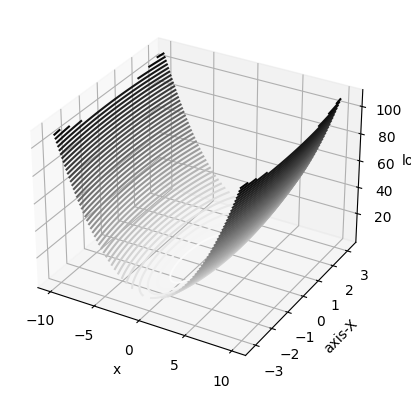

In [46]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, axis_X, l, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('axis-X')
ax.set_zlabel('loss');

In [47]:
def traj_loss(t1, t2):
    d = (t1 * t2.Inv()).Log()
    # Def make the vector a matrix for multiplication.
    left = d[..., None, :]
    right = d[..., None]
    return torch.matmul(left, right)[..., 0, 0]

# Testing:
Get two trajectories from two datasets. Compute the error between them and look at its evolution with the trajectory length too.

In [48]:
path1 = "./data/csv/sub/run10.csv"
path2 = "./data/csv/sub/run100.csv"

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

# Exapand first dimension to simulate k=1
traj1 = df1.loc[:, ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']].to_numpy()[None, ...] 
traj2 = df2.loc[:, ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']].to_numpy()[None, ...]

# Convert them to pypose representation
traj1_pp = pp.SE3(traj1)
traj2_pp = pp.SE3(traj2)

In [49]:
l = traj_loss(traj1_pp, traj2_pp)

cum_l = torch.cumsum(l, 1)
print(cum_l.shape)

torch.Size([1, 500])


/home/pierre/anaconda3/envs/pypose/lib/python3.9/site-packages/pypose/lietensor/lietensor.py:919: UserWarning: Tensor Shape Invalid by calling <slot wrapper '__getitem__' of 'torch._C._TensorBase' objects>, go to https://pypose.org/docs/main/generated/pypose.LieTensor
  warnings.warn('Tensor Shape Invalid by calling {}, ' \


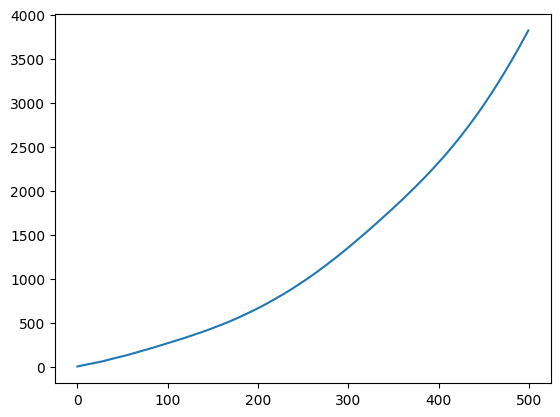

In [50]:
plt.plot(cum_l[0].numpy())

In [51]:
print(cum_l[0, -1])
print(l.sum(-1))

tensor(3823.7163)
tensor([3823.7163])


In [52]:
# k = 3, tau = 5
vel = torch.randn(3, 5, 6)
vel_hat = torch.rand(3, 5, 6)

In [53]:
l2 = torch.nn.MSELoss()
u = l2(vel[..., 0], vel_hat[..., 0])
v = l2(vel[..., 1], vel_hat[..., 1])
w = l2(vel[..., 2], vel_hat[..., 2])
p = l2(vel[..., 3], vel_hat[..., 3])
q = l2(vel[..., 4], vel_hat[..., 4])
r = l2(vel[..., 5], vel_hat[..., 5])

print(u)
print(v)
print(w)
print(p)
print(q)
print(r)


print(l2(vel, vel_hat))
print((u+v+w+p+q+r)/6.)

tensor(1.4471)
tensor(0.9848)
tensor(0.5290)
tensor(1.5278)
tensor(1.9261)
tensor(1.1627)
tensor(1.2629)
tensor(1.2629)


In [54]:
print(torch.pow(vel - vel_hat, 2).mean((0, 1)).shape)

torch.Size([6])


# Normalizde dv.

Load the dv from the csv file.

plot histogram to see data distrubution and make sure gaussian assumption is true.

Compute mean and STD for dv.



In [55]:
data_dir = "./data/csv/sub/"
dir_name = os.path.basename(data_dir)
files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

In [78]:
Bdvs = []
Idvs = []
for f in files:
    df = pd.read_csv(os.path.join(data_dir, f))
    Bdv = df.loc[:, ["Bdu", "Bdv", "Bdw", "Bdp", "Bdq", "Bdr"]].to_numpy()
    Idv = df.loc[:, ["Idu", "Idv", "Idw", "Idp", "Idq", "Idr"]].to_numpy()
    Bdvs.append(Bdv)
    Idvs.append(Idv)

Bdvs = np.concatenate(Bdvs, axis=0)
Idvs = np.concatenate(Idvs, axis=0)
print(Bdvs.shape)

(25000, 6)


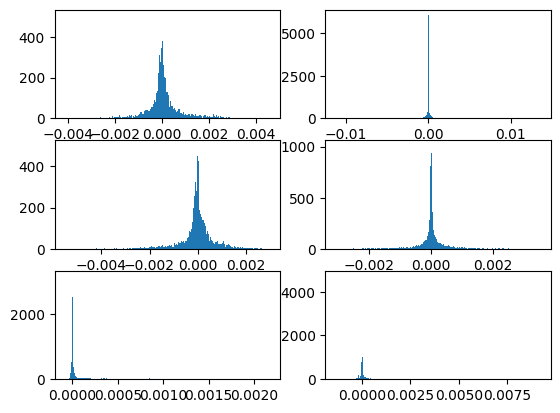

In [80]:
plt.subplot(3, 2, 1)
plt.hist(Bdvs[:, 0], 1000);

plt.subplot(3, 2, 3)
plt.hist(Bdvs[:, 1], 1000);

plt.subplot(3, 2, 5)
plt.hist(Bdvs[:, 2], 1000);

plt.subplot(3, 2, 2)
plt.hist(Bdvs[:, 3], 1000);

plt.subplot(3, 2, 4)
plt.hist(Bdvs[:, 4], 1000);

plt.subplot(3, 2, 6)
plt.hist(Bdvs[:, 5], 1000);


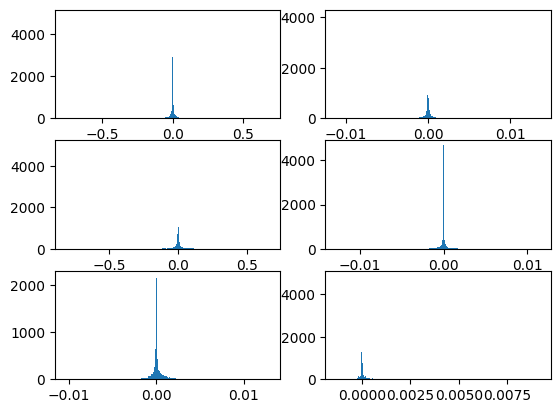

In [81]:
plt.subplot(3, 2, 1)
plt.hist(Idvs[:, 0], 1000);

plt.subplot(3, 2, 3)
plt.hist(Idvs[:, 1], 1000);

plt.subplot(3, 2, 5)
plt.hist(Idvs[:, 2], 1000);

plt.subplot(3, 2, 2)
plt.hist(Idvs[:, 3], 1000);

plt.subplot(3, 2, 4)
plt.hist(Idvs[:, 4], 1000);

plt.subplot(3, 2, 6)
plt.hist(Idvs[:, 5], 1000);


In [83]:
Bm = np.mean(Bdvs, axis=0)
Bstd = np.std(Bdvs, axis=0)
print(Bm)
print(Bstd)

[ 1.16349021e-04 -3.26835892e-05  1.40047013e-04  5.24958706e-07
  1.19974079e-05  2.70614192e-04]
[0.00087042 0.00077489 0.00033608 0.0011941  0.00060541 0.00104279]


In [84]:
Im = np.mean(Idvs, axis=0)
Istd = np.std(Idvs, axis=0)
print(Im)
print(Istd)

[ 4.23669008e-05 -3.26155424e-04  1.32466790e-04  1.81975652e-06
 -2.33558411e-06  2.70641843e-04]
[0.05364677 0.05829255 0.00115433 0.00098418 0.00090732 0.00104314]


In [85]:
normed_Bdvs = (Bdvs - Bm)/Bstd
normed_Idvs = (Idvs - Im)/Istd

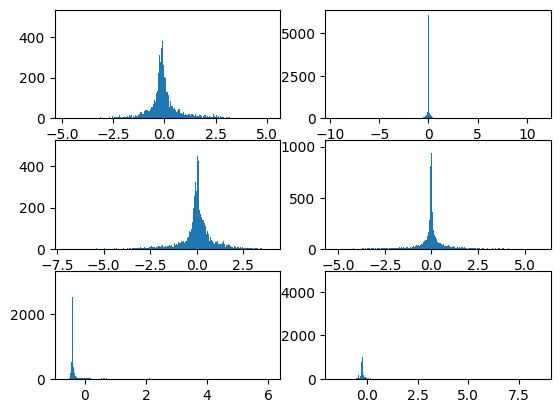

In [86]:
plt.subplot(3, 2, 1)
plt.hist(normed_Bdvs[:, 0], 1000);

plt.subplot(3, 2, 3)
plt.hist(normed_Bdvs[:, 1], 1000);

plt.subplot(3, 2, 5)
plt.hist(normed_Bdvs[:, 2], 1000);

plt.subplot(3, 2, 2)
plt.hist(normed_Bdvs[:, 3], 1000);

plt.subplot(3, 2, 4)
plt.hist(normed_Bdvs[:, 4], 1000);

plt.subplot(3, 2, 6)
plt.hist(normed_Bdvs[:, 5], 1000);


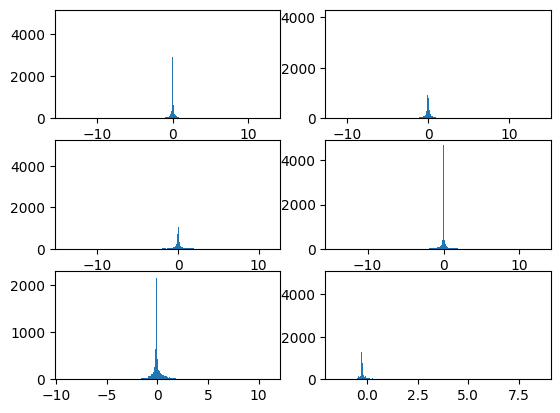

In [87]:
plt.subplot(3, 2, 1)
plt.hist(normed_Idvs[:, 0], 1000);

plt.subplot(3, 2, 3)
plt.hist(normed_Idvs[:, 1], 1000);

plt.subplot(3, 2, 5)
plt.hist(normed_Idvs[:, 2], 1000);

plt.subplot(3, 2, 2)
plt.hist(normed_Idvs[:, 3], 1000);

plt.subplot(3, 2, 4)
plt.hist(normed_Idvs[:, 4], 1000);

plt.subplot(3, 2, 6)
plt.hist(normed_Idvs[:, 5], 1000);


In [89]:
print(np.mean(normed_Bdvs, axis=0))
print(np.std(normed_Bdvs, axis=0))

[-2.27373675e-18  9.23705556e-19  3.63797881e-17  2.70006240e-18
  7.81597009e-19  3.01270120e-17]
[1. 1. 1. 1. 1. 1.]


In [90]:
print(np.mean(normed_Idvs, axis=0))
print(np.std(normed_Idvs, axis=0))

[-3.44169138e-18 -3.83693077e-18 -1.32160949e-17 -3.97903932e-18
  3.10862447e-18 -6.25277607e-18]
[1. 1. 1. 1. 1. 1.]


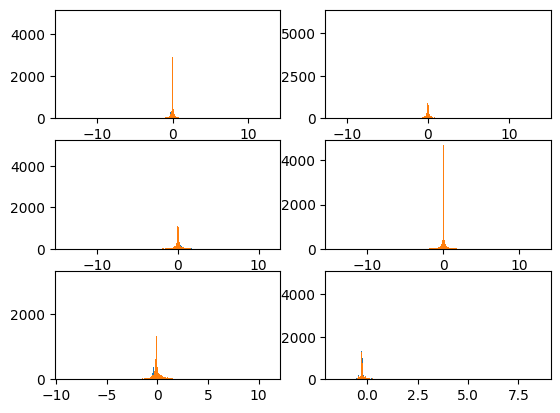

In [91]:
plt.subplot(3, 2, 1)
plt.hist(normed_Bdvs[:, 0], 1000);
plt.hist(normed_Idvs[:, 0], 1000);

plt.subplot(3, 2, 3)
plt.hist(normed_Bdvs[:, 1], 1000);
plt.hist(normed_Idvs[:, 1], 1000);

plt.subplot(3, 2, 5)
plt.hist(normed_Bdvs[:, 2], 1000);
plt.hist(normed_Idvs[:, 2], 1000);

plt.subplot(3, 2, 2)
plt.hist(normed_Bdvs[:, 3], 1000);
plt.hist(normed_Idvs[:, 3], 1000);

plt.subplot(3, 2, 4)
plt.hist(normed_Bdvs[:, 4], 1000);
plt.hist(normed_Idvs[:, 4], 1000);

plt.subplot(3, 2, 6)
plt.hist(normed_Bdvs[:, 5], 1000);
plt.hist(normed_Idvs[:, 5], 1000);